2025-04-11 13:59:14,500 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.839
2025-04-11 13:59:32,578 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.8389409462415103, best pos: [47.02664665  0.6041989   8.09356934  1.13916689 23.58691456]



✅ Best parameters from PSO (custom init):
   k = 47
   weights = 'distance'
   p = 8
   metric = 'manhattan'
   leaf_size = 24
🎯 Final test accuracy: 0.8339


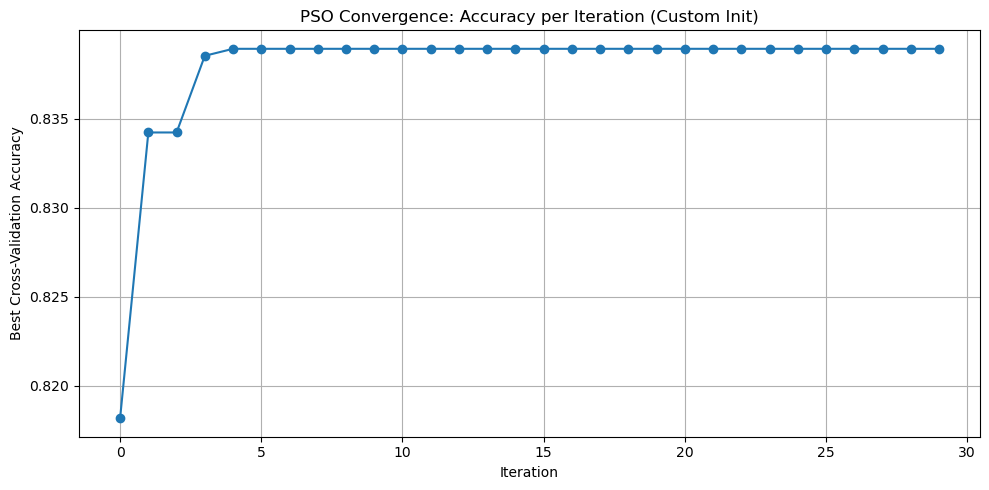

In [1]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from pyswarms.single import GlobalBestPSO
import matplotlib.pyplot as plt

# Step 1: Load and encode dataset
dataset = fetch_ucirepo(id=69)
X_raw = dataset.data.features
y_raw = dataset.data.targets

X = OrdinalEncoder().fit_transform(X_raw)
y = LabelEncoder().fit_transform(y_raw.values.ravel())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Setup options
weights_options = ['uniform', 'distance']
metric_options = ['minkowski', 'manhattan', 'chebyshev']

n_particles = 10
dimensions = 5
max_iter = 30
np.random.seed(42)  # 🔐 Fixed seed for reproducibility

# Step 3: Define bounds and initial positions
bounds = (
    np.array([1, 0, 1, 0, 10]),   # lower bounds
    np.array([50, 1, 10, 2, 100]) # upper bounds
)

# Optional: manually fix initial particle positions (uniformly spread)
init_pos = np.random.uniform(low=bounds[0], high=bounds[1], size=(n_particles, dimensions))

# Step 4: Define objective function
def objective_function(swarm):
    results = []
    for params in swarm:
        try:
            k = int(round(params[0]))
            w_idx = int(round(params[1]))
            p = int(round(params[2]))
            metric_idx = int(round(params[3]))
            leaf_size = int(round(params[4]))

            if (k < 1 or k > 50 or w_idx not in [0,1] or
                p < 1 or p > 10 or metric_idx not in [0,1,2] or
                leaf_size < 10 or leaf_size > 100):
                results.append(1.0)
                continue

            model = KNeighborsClassifier(
                n_neighbors=k,
                weights=weights_options[w_idx],
                p=p,
                metric=metric_options[metric_idx],
                leaf_size=leaf_size
            )
            score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
            results.append(-score)  # Minimize negative accuracy
        except:
            results.append(1.0)
    return np.array(results)

# Step 5: Run PSO
options = {'c1': 1.5, 'c2': 1.5, 'w': 0.5}
optimizer = GlobalBestPSO(
    n_particles=n_particles,
    dimensions=dimensions,
    options=options,
    bounds=bounds,
    init_pos=init_pos
)

cost, best_position = optimizer.optimize(objective_function, iters=max_iter)

# Step 6: Extract and evaluate best model
best_k = int(round(best_position[0]))
best_weights = weights_options[int(round(best_position[1]))]
best_p = int(round(best_position[2]))
best_metric = metric_options[int(round(best_position[3]))]
best_leaf = int(round(best_position[4]))

final_model = KNeighborsClassifier(
    n_neighbors=best_k,
    weights=best_weights,
    p=best_p,
    metric=best_metric,
    leaf_size=best_leaf
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)

print("\n✅ Best parameters from PSO (custom init):")
print(f"   k = {best_k}")
print(f"   weights = '{best_weights}'")
print(f"   p = {best_p}")
print(f"   metric = '{best_metric}'")
print(f"   leaf_size = {best_leaf}")
print(f"🎯 Final test accuracy: {final_accuracy:.4f}")

# Step 7: Plot convergence
plt.figure(figsize=(10, 5))
plt.plot(-np.array(optimizer.cost_history), marker='o')
plt.title("PSO Convergence: Accuracy per Iteration (Custom Init)")
plt.xlabel("Iteration")
plt.ylabel("Best Cross-Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()
